<ipython-input-12-642693266a7f>:13: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv("/content/preprocessed_train_data (1).csv")
<ipython-input-12-642693266a7f>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[target_col].fillna(train_df[target_col].mode()[0], inplace=True)
<ipython-input-12-642693266a7f>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

Training Decision Tree Classifier with max_depth=5...
 Decision Tree Classification Report:
              precision    recall  f1-score   support

           1       0.95      0.97      0.96     37797
           2       0.84      0.96      0.89     31012
           3       0.79      0.63      0.70      5481
           4       0.97      0.94      0.95     34487
           5       0.73      0.87      0.79      6670
           6       0.96      0.83      0.89     33842

    accuracy                           0.91    149289
   macro avg       0.87      0.87      0.87    149289
weighted avg       0.92      0.91      0.91    149289

 Decision Tree Confusion Matrix:


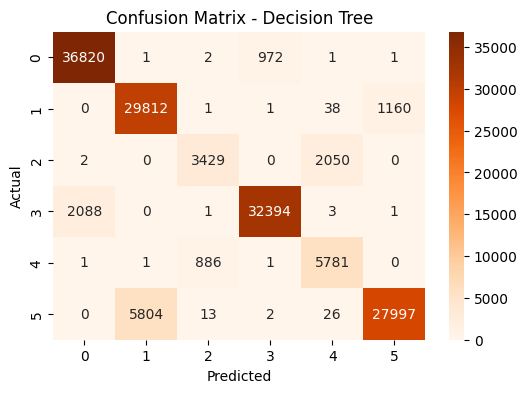

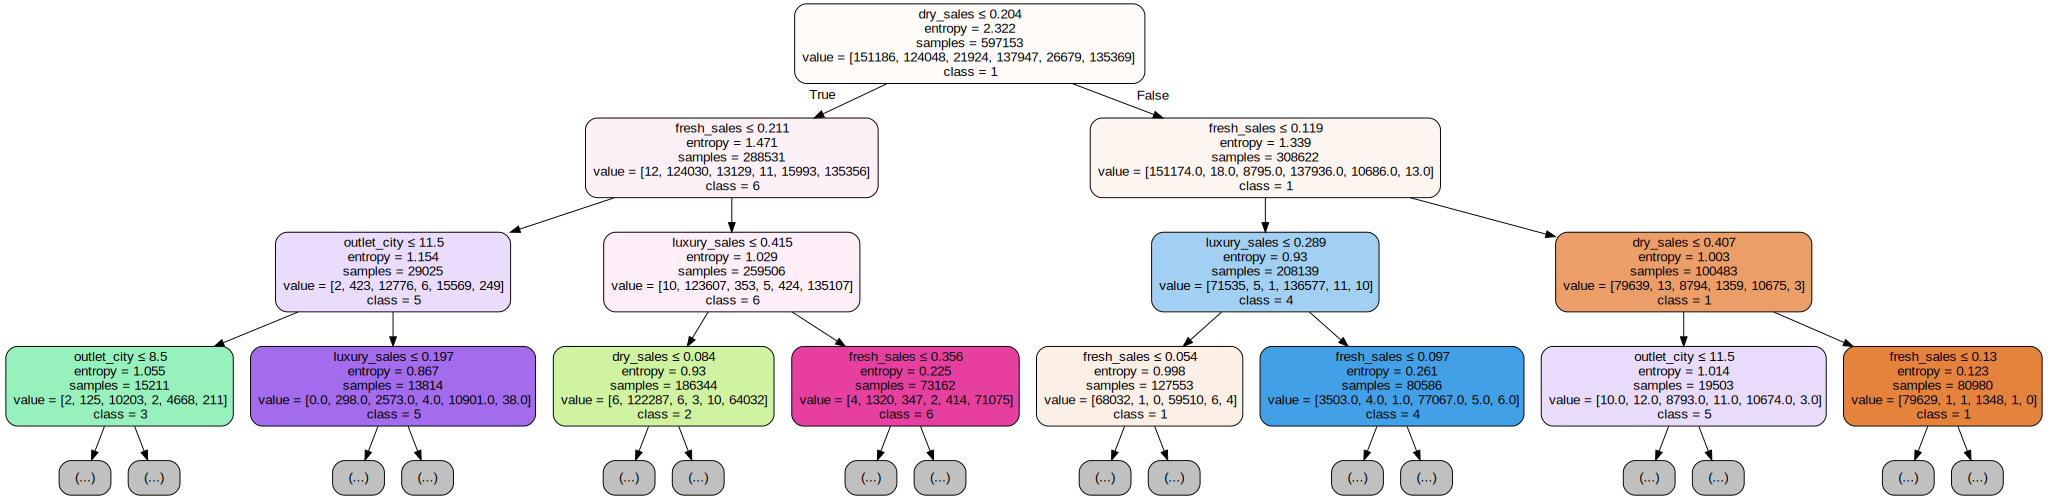

Predicted Clusters for Test Dataset:
   Customer_ID  Predicted_cluster
0        33574                  1
1        10089                  1
2        38329                  1
3        11376                  1
4        12410                  1
5          826                  1
6        10364                  4
7        39986                  1
8        11133                  1
9        32747                  1
 Test Set Prediction Distribution:
Predicted_cluster
1    10485
2     9440
4     8793
6     7607
5     2698
3     1726
Name: count, dtype: int64


In [12]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler

# Step 2: Load Datasets
train_df = pd.read_csv("/content/preprocessed_train_data (1).csv")
test_df = pd.read_csv("/content/preprocessed_test_data (1).csv")

# Step 3: Encode 'outlet_city'
combined_cities = pd.concat([train_df["outlet_city"], test_df["outlet_city"]], axis=0).astype(str)
city_encoder = LabelEncoder()
city_encoder.fit(combined_cities)

train_df["outlet_city"] = city_encoder.transform(train_df["outlet_city"].astype(str))
test_df["outlet_city"] = city_encoder.transform(test_df["outlet_city"].astype(str))

# Step 4: Clean & Convert Target Column
target_col = "cluster_catgeory"
train_df[target_col].fillna(train_df[target_col].mode()[0], inplace=True)
train_df[target_col] = train_df[target_col].astype(str).str.extract("(\d+)")[0]
train_df = train_df[train_df[target_col].notna()]
train_df[target_col] = train_df[target_col].astype(int)

# Keep only top 6 most frequent classes
top_classes = train_df[target_col].value_counts().nlargest(6).index
train_df = train_df[train_df[target_col].isin(top_classes)]

# Step 5: Feature Scaling
scaler = MinMaxScaler()
numeric_cols = ['luxury_sales', 'fresh_sales', 'dry_sales']
train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

# Step 6: Define Features and Target
X = train_df.drop(columns=["Customer_ID", target_col])
y = train_df[target_col]

# Step 7: Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 8: Train Decision Tree Classifier with Limited Depth
print("Training Decision Tree Classifier with max_depth=5...")
dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)
y_val_pred_dt = dt_model.predict(X_val)

# Step 9: Evaluate the Model
print(" Decision Tree Classification Report:")
print(classification_report(y_val, y_val_pred_dt))

print(" Decision Tree Confusion Matrix:")
cm_dt = confusion_matrix(y_val, y_val_pred_dt)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 10: Visualize the Decision Tree (High Clarity)
from sklearn.tree import export_graphviz
import graphviz

# Export tree to DOT format (graph description language)
dot_data = export_graphviz(
    dt_model,
    out_file=None,
    feature_names=X.columns,
    class_names=[str(cls) for cls in dt_model.classes_],
    filled=True,
    rounded=True,
    special_characters=True,
    max_depth=3  # limit depth for better readability
)

# Render using Graphviz
graph = graphviz.Source(dot_data)
graph.render("decision_tree", format='pdf', cleanup=True)  # Save as PDF (high clarity)
graph.view()

# Optional: Show inline in Colab as SVG
from IPython.display import SVG
graph_svg = graphviz.Source(dot_data, format='svg')
display(SVG(graph_svg.pipe(format='svg')))

# Step 11: Predict on Test Dataset
X_test = test_df.drop(columns=["Customer_ID"])
test_predictions = dt_model.predict(X_test)
test_df["Predicted_cluster"] = test_predictions

# Step 12: Show Test Predictions
print("Predicted Clusters for Test Dataset:")
print(test_df[["Customer_ID", "Predicted_cluster"]].head(10))

# Step 13: Test Set Prediction Distribution
print(" Test Set Prediction Distribution:")
print(test_df["Predicted_cluster"].value_counts())

# Step 14: Export Results
test_df.to_csv("decision_tree_test_predictions.csv", index=False)
